In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              ])

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

!mkdir data
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
valset = datasets.MNIST('data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

A subdirectory or file data already exists.


In [40]:
# Make a generative advisarial network with pytorch designed for mnist
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 28*28)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [55]:
generator = Generator()
discriminator = Discriminator()

lr = 1e-3
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_criterion = nn.BCELoss()
d_criterion = nn.BCELoss()

n_epochs = 10
for epoch in tqdm(range(1, n_epochs + 1)):
    generator.train()
    discriminator.train()
    for x, y in trainloader:
        y = y.view(-1, 1).float()
        noise = torch.randn(x.shape[0], generator.latent_dim).to(device)
        x_hat = generator(noise)
        y_hat = torch.zeros(x.shape[0], 1).to(device)
        
        pred = discriminator(x.view(x.shape[0], -1).to(device))
        # real loss)
        d_loss  = d_criterion(pred, y)
        # fake loss
        pred = discriminator(x_hat.view(x.shape[0], -1).to(device))
        d_loss += d_criterion(pred, y_hat)
        # compute generator loss
        g_loss = g_criterion(pred, y_hat)

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

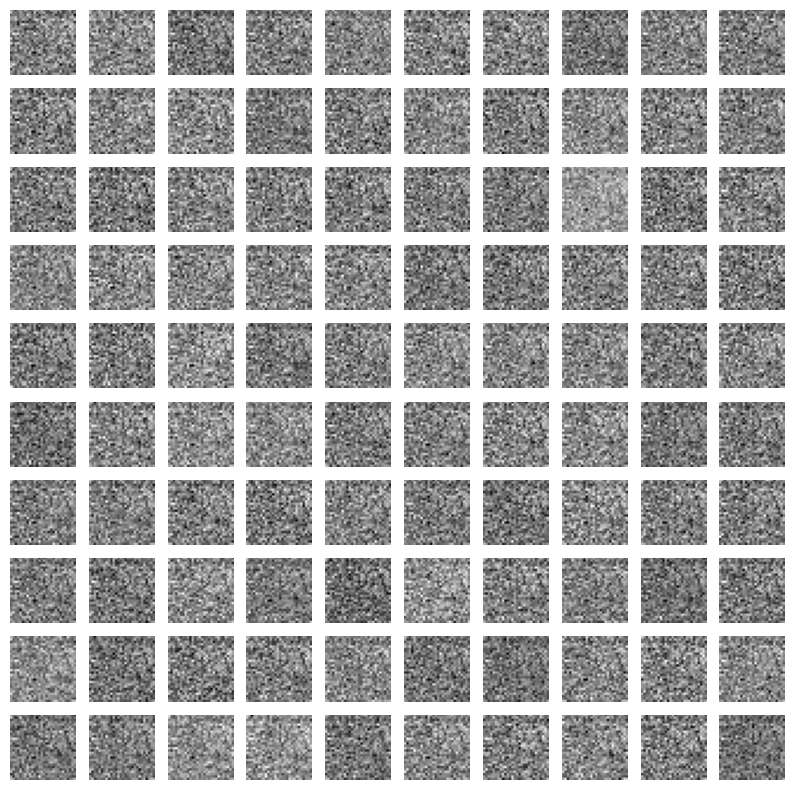

In [46]:

# write a function to generate a grid of images
def generate_grid(generator, latent_dim=100, n=10):
    noise = torch.randn(n*n, latent_dim).to(device)
    x_hat = generator(noise)
    x_hat = x_hat.view(-1, 28, 28)
    x_hat = x_hat.detach().cpu().numpy()
    x_hat = np.transpose(x_hat, (1, 2, 0))
    fig, ax = plt.subplots(n, n, figsize=(n, n))
    for i in range(n):
        for j in range(n):
            ax[i, j].imshow(x_hat[:, :, i*n + j], cmap='gray')
            ax[i, j].axis('off')
    plt.show()

generate_grid(generator)